In [207]:
import time
import warnings
import importlib
import numpy as np
import pandas as pd
import seaborn as sns
from astropy import units as u
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.optimize import curve_fit
import sympy as smp
from astropy.coordinates import SkyCoord
from astropy.cosmology import Planck18

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
warnings.filterwarnings('ignore')
import galaxy_phot as glp
import ztfidr

sample = ztfidr.get_sample().data
df_iso = pd.read_csv('csv_files/galaxy_isophotes.csv', index_col=0)
c1_df = pd.read_csv('csv_files/one_decomp.csv', index_col=0)
c2_df = pd.read_csv('csv_files/two_decomp.csv', index_col=0)
c3_df = pd.read_csv('csv_files/three_decomp.csv', index_col=0)
df_gal = pd.read_csv('csv_files/SNIa_galaxy_3.csv', index_col=0)
df_gal['sn_gal_type'][df_gal['n_fits'] == 1] = 'sersic <1'
df_gal = df_gal[df_gal['z'] != 0]
targets = df_iso['sn_name'].unique()
len(targets), len(sample), round(len(targets)/len(sample), 2)

(3035, 3629, 0.84)

In [208]:
importlib.reload(glp) 

<module 'galaxy_phot' from 'c:\\Users\\Robert\\PycharmProjects\\galaxies\\galaxy_phot.py'>

In [209]:
min_len = []
for sni in targets:
    band_i = df_iso['band'][df_iso['sn_name'] == sni]
    min_len.append(min(band_i.value_counts().get('g', 0), band_i.value_counts().get('r', 0)))

In [210]:
n_contour = pd.Series(min_len, index=targets)
n_iso = len(n_contour[n_contour >= 10])
n_iso, len(targets), round(n_iso/len(targets), 2), round(n_iso/len(sample), 2)

(2326, 3035, 0.77, 0.64)

In [211]:
l1, l2 = len(c1_df[c1_df['ue_g'] != 0]), len(c2_df[c2_df['ue_g'] != 0])
l1, l2, round(l1/n_iso, 2), round(l2/n_iso, 2), round(l1/len(sample), 2), round(l2/len(sample), 2)

(1970, 1188, 0.85, 0.51, 0.54, 0.33)

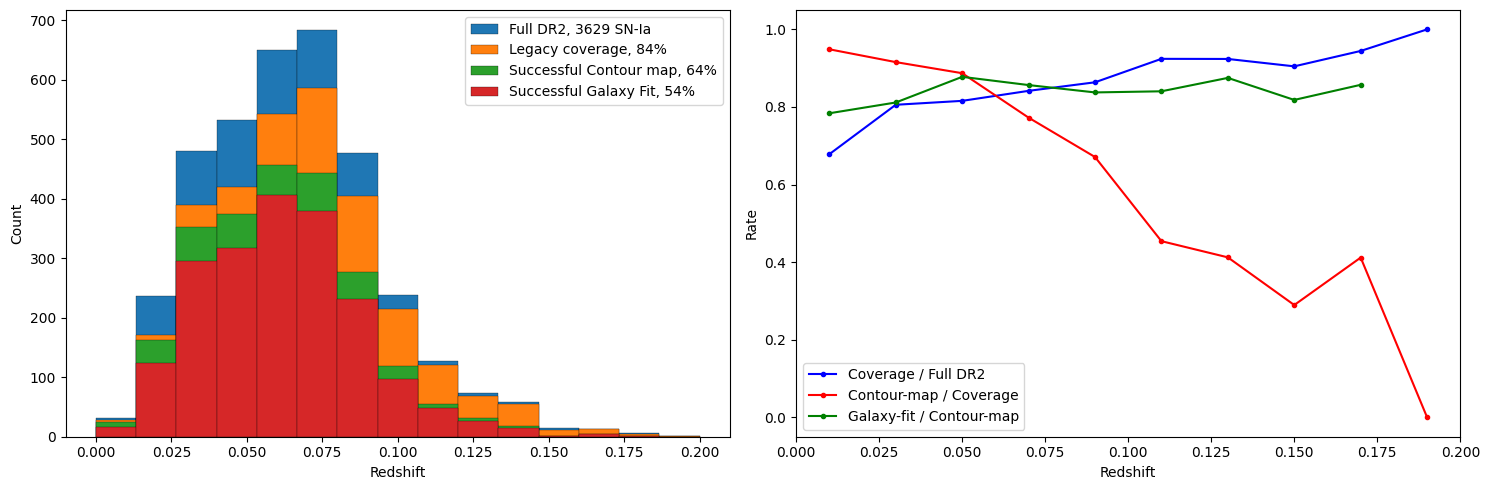

In [212]:
fig, (ax1, ax2) = plt.subplots(figsize=(15, 5), dpi=100, ncols=2)

tot = sample['redshift']
targs = sample.loc[targets]['redshift']
iso = sample.loc[n_contour[n_contour >= 10].index]['redshift']
bd1 = sample.loc[c1_df[c1_df['ue_g'] != 0]['sn_name']]['redshift']
bd2 = sample.loc[c2_df[c2_df['ue_g'] != 0]['sn_name']]['redshift']
bd3 = sample.loc[c3_df[c3_df['ue_bulge_g'] != 0]['sn_name']]['redshift']
bins= 15

tot.hist(bins=bins, ax=ax1, range=(0,0.2), ec='black', lw=0.2, label='Full DR2, 3629 SN-Ia')
targs.hist(bins=bins, ax=ax1, range=(0,0.2),ec='black', lw=0.2, label='Legacy coverage, 84%')
iso.hist(bins=bins, ax=ax1, range=(0,0.2), ec='black', lw=0.2, label='Successful Contour map, 64%')
bd1.hist(bins=bins, ax=ax1, range=(0,0.2), ec='black', lw=0.2, label='Successful Galaxy Fit, 54%')
ax1.grid(False)
ax1.legend()
ax1.set_ylabel('Count')
ax1.set_xlabel('Redshift')

bins_=10
tot_v, bins1 = np.histogram(tot, bins=bins_, range=(0, 0.2))
targs_v, bins2 = np.histogram(targs, bins=bins_, range=(0, 0.2))
iso_v, bins3 = np.histogram(iso, bins=bins_, range=(0, 0.2))
bd1_v, bins4 = np.histogram(bd1, bins=bins_, range=(0, 0.2))
ax2.plot((bins1[:-1]+bins1[1:])/2, targs_v/tot_v, 'b.-', label='Coverage / Full DR2')
ax2.plot((bins2[:-1]+bins2[1:])/2, iso_v/targs_v, 'r.-', label='Contour-map / Coverage')
ax2.plot((bins3[:-1]+bins3[1:])/2, bd1_v/iso_v, 'g.-', label='Galaxy-fit / Contour-map')
ax2.set_xlim([0, 0.2])
ax2.legend()
ax2.set_ylabel('Rate')
ax2.set_xlabel('Redshift')
plt.tight_layout()

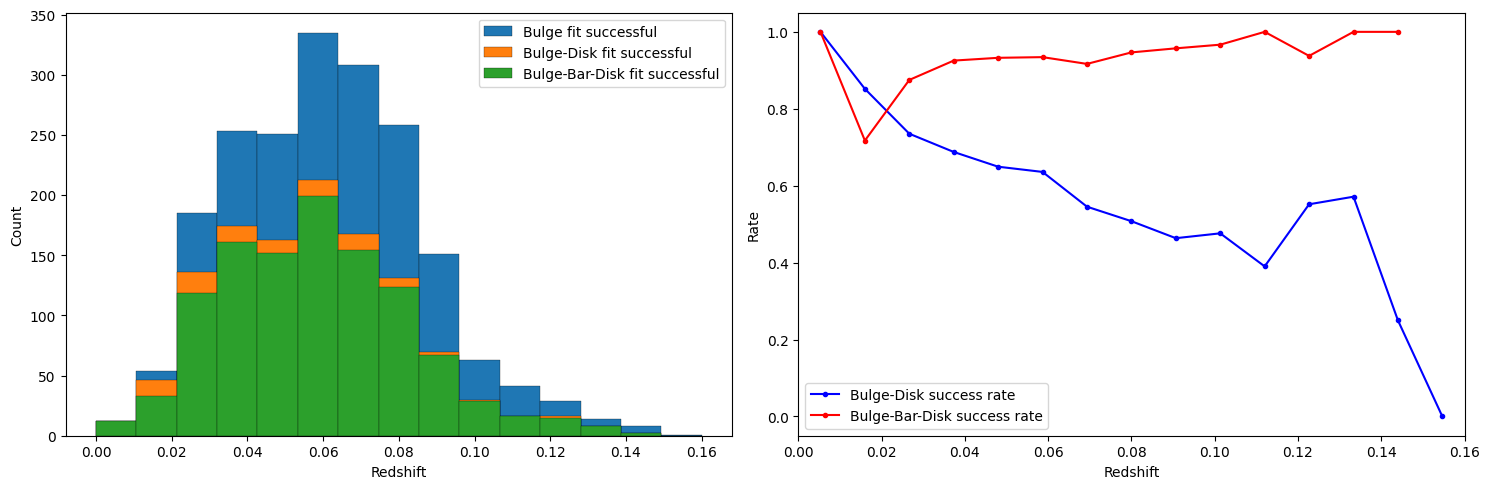

In [213]:
bins=15
fig, (ax1, ax2) = plt.subplots(figsize=(15, 5), dpi=100, ncols=2)
bd1.hist(bins=bins, ax=ax1, range=(0,0.16), ec='black', lw=0.2, label='Bulge fit successful')
bd2.hist(bins=bins, ax=ax1, range=(0,0.16), ec='black', lw=0.2, label='Bulge-Disk fit successful')
bd3.hist(bins=bins, ax=ax1, range=(0,0.16), ec='black', lw=0.2, label='Bulge-Bar-Disk fit successful')
ax1.grid(False)
ax1.legend()
ax1.set_ylabel('Count')
ax1.set_xlabel('Redshift')


bdv_1, bins1 = np.histogram(bd1, bins=bins, range=(0, 0.16))
bdv_2, bins2 = np.histogram(bd2, bins=bins, range=(0, 0.16))
bdv_3, bins3 = np.histogram(bd3, bins=bins, range=(0, 0.16))

ax2.plot((bins1[:-1]+bins1[1:])/2, bdv_2/bdv_1, 'b.-', label='Bulge-Disk success rate')
ax2.plot((bins2[:-1]+bins2[1:])/2, bdv_3/bdv_2, 'r.-', label='Bulge-Bar-Disk success rate')
ax2.set_xlim([0, 0.16])
ax2.legend()
ax2.set_ylabel('Rate')
ax2.set_xlabel('Redshift')
plt.tight_layout()

Bulge: $\mu(R) = \mu_e + \frac{2.5 b_n}{\ln 10} \left[(R/R_e)^{1/n} - 1\right]$, Free parameters: $\mu_e, R_e, n$

Disk: $\mu(R) = \mu_0 + \frac{2.5}{\ln 10} (R/h)$, Free parameters: $\mu_0, h$

In [215]:
df_gal = pd.read_csv('csv_files/SNIa_galaxy_3.csv', index_col=0)

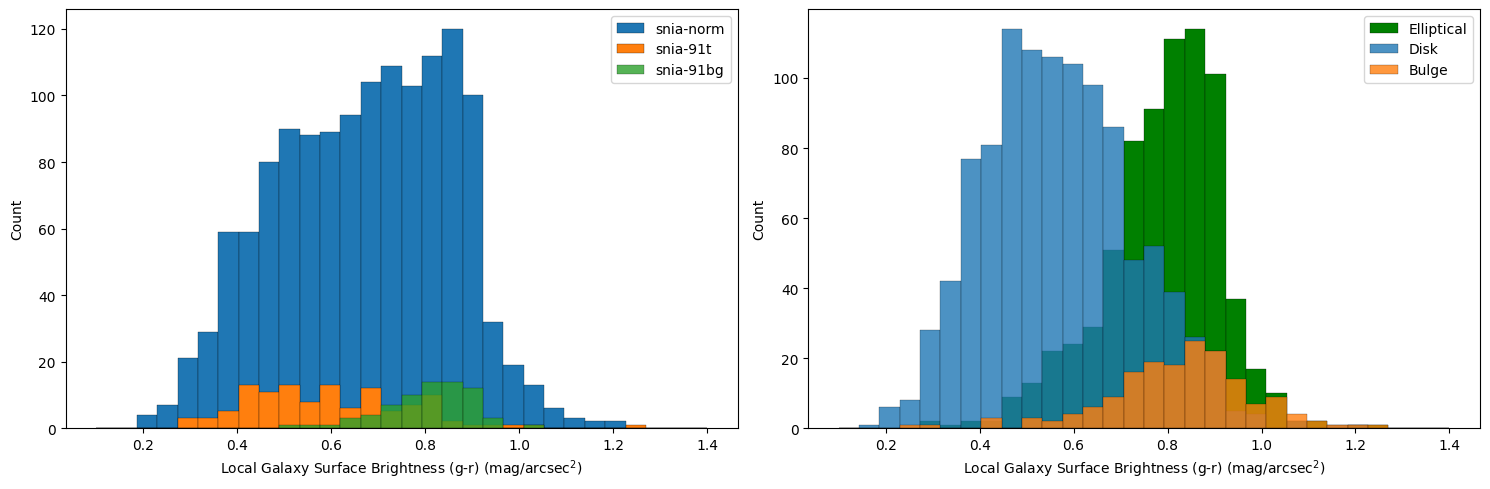

In [240]:
fig, (ax1, ax2) = plt.subplots(figsize=(15, 5), dpi=100, ncols=2)
df_gal_c = df_gal.copy()#[(df_gal['n_fits'] != 1) & (df_gal['z'] < 0.3)]
df_gal_c['sn_gal_type'][df_gal_c['sn_gal_type'] == 'disk_nb'] = 'disk'

local_norm = df_gal[df_gal['sntype'] == 'snia-norm']
local_norm_c = local_norm['sn_c_g'] - local_norm['sn_c_r']

local_91bg = df_gal[df_gal['sntype'] == 'snia-pec-91bg']
local_91bg_c = local_91bg['sn_c_g'] - local_91bg['sn_c_r']

local_91t = df_gal[df_gal['sntype'] == 'snia-pec-91t']
local_91t_c = local_91t['sn_c_g'] - local_91t['sn_c_r']

bins = 30
range_r = (0.1, 1.4)
local_norm_c.hist(bins=bins, range=range_r, label='snia-norm', ax=ax1, ec='black', lw=0.2, alpha=1)
local_91t_c.hist(bins=bins, range=range_r, label='snia-91t', ax=ax1, ec='black', lw=0.2, alpha=1)
local_91bg_c.hist(bins=bins, range=range_r, label='snia-91bg', ax=ax1, ec='black', lw=0.2,alpha=0.8)

ax1.grid(False)
ax1.legend()
ax1.set_ylabel('Count')
ax1.set_xlabel(r'Local Galaxy Surface Brightness (g-r) (mag/arcsec$^2$)')

local_bulge = df_gal_c[df_gal_c['sn_gal_type'] == 'bulge']
local_bulge_c = local_bulge['sn_c_g'] - local_bulge['sn_c_r']

local_disk = df_gal_c[(df_gal_c['sn_gal_type'] == 'disk')]
local_disk_c = local_disk['sn_c_g'] - local_disk['sn_c_r']

local_ell = df_gal_c[df_gal_c['sn_gal_type'] == 'elliptical']
local_ell_c = local_ell['sn_c_g'] - local_ell['sn_c_r']


bins = 30
range_r = (0.1, 1.4)
local_ell_c.hist(bins=bins, range=range_r, label='Elliptical', ax=ax2, ec='black', lw=0.2, alpha=1, color='green')
local_disk_c.hist(bins=bins, range=range_r, label='Disk', ax=ax2, ec='black', lw=0.2, alpha=0.8)
local_bulge_c.hist(bins=bins, range=range_r, label='Bulge', ax=ax2, ec='black', lw=0.2,alpha=0.8)

ax2.grid(False)
ax2.legend()
ax2.set_ylabel('Count')
ax2.set_xlabel(r'Local Galaxy Surface Brightness (g-r) (mag/arcsec$^2$)')
plt.tight_layout()

In [235]:
df_sam = df_gal[(df_gal['z'] != 0) & (df_gal['z'] < 0.1) & (df_gal['rss_fit'] < 1) & (df_gal['gal_type'].apply(lambda x: x[-1]) != 'u') & (df_gal['gal_type'] != 'too-close')]
df_sam['sn_gal_type'][df_sam['sn_gal_type'] == 'disk_nb'] = 'disk'
len(df_sam)

1093

In [238]:
cne = df_sam[(df_sam['sntype'] == 'snia-norm') & (df_sam['sn_gal_type'] == 'elliptical')]
cnd = df_sam[(df_sam['sntype'] == 'snia-norm') & (df_sam['sn_gal_type'] == 'disk')]
cnb = df_sam[(df_sam['sntype'] == 'snia-norm') & (df_sam['sn_gal_type'] == 'bulge')]

cte = df_sam[(df_sam['sntype'] == 'snia-pec-91t') & (df_sam['sn_gal_type'] == 'elliptical')]
ctd = df_sam[(df_sam['sntype'] == 'snia-pec-91t') & (df_sam['sn_gal_type'] == 'disk')]
ctb = df_sam[(df_sam['sntype'] == 'snia-pec-91t') & (df_sam['sn_gal_type'] == 'bulge')]

cbe = df_sam[(df_sam['sntype'] == 'snia-pec-91bg') & (df_sam['sn_gal_type'] == 'elliptical')]
cbd = df_sam[(df_sam['sntype'] == 'snia-pec-91bg') & (df_sam['sn_gal_type'] == 'disk')]
cbb = df_sam[(df_sam['sntype'] == 'snia-pec-91bg') & (df_sam['sn_gal_type'] == 'bulge')]

vals = np.array([[len(cne), len(cnd), len(cnb)], [len(cte)-4, len(ctd), len(ctb)-3], [len(cbe), len(cbd)-5, len(cbb)]])

Text(0.5, 33.22222222222222, 'Galaxy subtype')

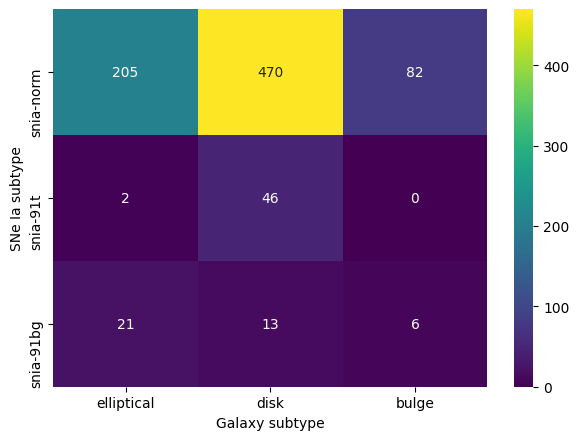

In [239]:

fig, ax = plt.subplots(figsize=(7, 5), dpi=100)
sns.heatmap(vals, xticklabels=['elliptical', 'disk', 'bulge'], yticklabels=['snia-norm', 'snia-91t', 'snia-91bg'], annot=True, cmap='viridis', fmt='d')
ax.set_ylabel('SNe Ia subtype')
ax.set_xlabel('Galaxy subtype')

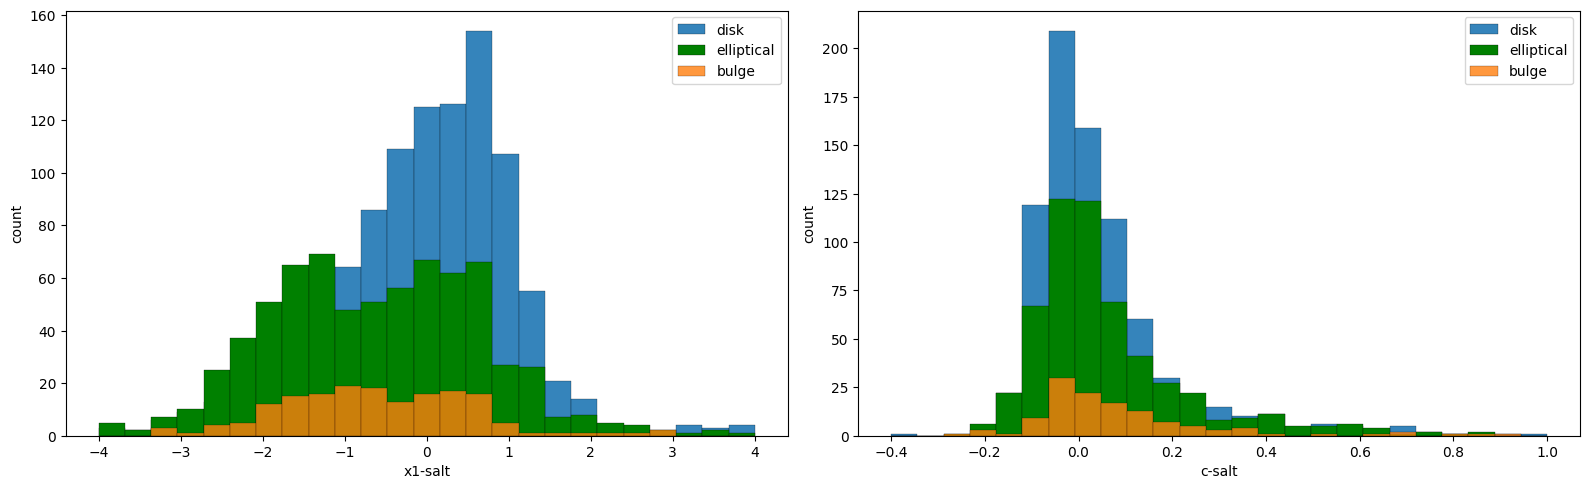

In [217]:
fig, (ax1, ax2) = plt.subplots(figsize=(16, 5), dpi=100, ncols=2)
cuts = (df_gal_c['lc_flag'] == 1)
bins=25
data_x1 = df_gal_c['x1_salt']
r_r1 =  (-4, 4)
data_x1[df_gal_c['sn_gal_type'] == 'disk'].hist(bins=bins, range=r_r1, label='disk', ax=ax1, ec='black', lw=0.2, alpha=0.9)
data_x1[df_gal_c['sn_gal_type'] == 'elliptical'].hist(bins=bins, range=r_r1, label='elliptical', ax=ax1, ec='black', lw=0.2, alpha=1, color='green')

data_x1[df_gal_c['sn_gal_type'] == 'bulge'].hist(bins=bins, range=r_r1, label='bulge', ax=ax1, ec='black', lw=0.2, alpha=0.8)

ax1.legend()
ax1.grid(False)
ax1.set_ylabel('count')
ax1.set_xlabel('x1-salt')

data_c = df_gal_c['c_salt'][cuts]
data_c[df_gal_c['sn_gal_type'] == 'disk'].hist(bins=bins, range=(-0.4, 1), label='disk', ax=ax2, ec='black', lw=0.2, alpha=0.9)
data_c[df_gal_c['sn_gal_type'] == 'elliptical'].hist(bins=bins, range=(-0.4, 1), label='elliptical', ax=ax2, ec='black', lw=0.2, alpha=1, color='green')

data_c[df_gal_c['sn_gal_type'] == 'bulge'].hist(bins=bins, range=(-0.4, 1), label='bulge', ax=ax2, ec='black', lw=0.2, alpha=0.8)

ax2.grid(False)
ax2.legend()
ax2.set_ylabel('count')
ax2.set_xlabel('c-salt')

plt.tight_layout()

In [95]:
# fig, (ax1, ax2) = plt.subplots(figsize=(15, 5), dpi=100, ncols=2)

# local_norm = df_gal[df_gal['sntype'] == 'snia-norm']
# local_norm_c = local_norm['SB_center_g']

# local_91bg = df_gal[df_gal['sntype'] == 'snia-pec-91bg']
# local_91bg_c = local_91bg['SB_center_g']

# local_91t = df_gal[df_gal['sntype'] == 'snia-pec-91t']
# local_91t_c = local_91t['SB_center_g']

# bins = 20
# range_r = (13.7, 24)
# local_norm_c.hist(bins=bins, range=range_r, label='snia-norm', ax=ax1, ec='black', lw=0.2, alpha=1)
# local_91t_c.hist(bins=bins, range=range_r, label='snia-91t', ax=ax1, ec='black', lw=0.2, alpha=0.9)
# local_91bg_c.hist(bins=bins, range=range_r, label='snia-91bg', ax=ax1, ec='black', lw=0.2,alpha=0.9)

# ax1.grid(False)
# ax1.legend()
# ax1.set_ylabel('Count')
# ax1.set_xlabel(r'Central Surface Brightness (g) (mag/arcsec$^2$)')

# local_bulge = df_gal_c[df_gal_c['sn_gal_type'] == 'bulge']
# local_bulge_c = local_bulge['SB_center_g']

# local_disk = df_gal_c[df_gal_c['sn_gal_type'] == 'disk']
# local_disk_c = local_disk['SB_center_g']

# local_ell = df_gal_c[df_gal_c['sn_gal_type'] == 'elliptical']
# local_ell_c = local_ell['SB_center_g']

# local_one = df_gal[df_gal['n_fits'] == 1]
# local_one_c = local_one['SB_center_g']

# bins = 20
# range_r = (13.7, 24)

# local_disk_c.hist(bins=bins, range=range_r, label='Disk', ax=ax2, ec='black', lw=0.2, alpha=0.9)
# local_bulge_c.hist(bins=bins, range=range_r, label='Bulge', ax=ax2, ec='black', lw=0.2,alpha=0.8)
# local_ell_c.hist(bins=bins, range=range_r, label='Elliptical', ax=ax2, ec='black', lw=0.2, alpha=1, color='green')
# ax2.grid(False)
# ax2.legend()
# ax2.set_ylabel('Count')
# ax2.set_xlabel(r'Central Surface Brightness (g) (mag/arcsec$^2$)')
# plt.tight_layout()

In [1]:
# fig, (ax1, ax2) = plt.subplots(figsize=(18, 6), dpi=100, ncols=2, sharey=True)
# df_gal_s = df_gal.sort_values('sntype')
# df_gal_s['sn_gal_type'][df_gal_s['n_fits'] == 1] = 'sersic <1'
# cuts = (df_gal_s['z'] < 0.06)  

# y = df_gal_s['sn_c_g'][cuts] - df_gal_s['sn_c_r'][cuts]
# x = df_gal_s['SB_center_g'][cuts]
# hue = df_gal_s['sntype'][cuts]
# sizes = np.ones(len(hue.unique())) * 90
# sizes[np.where(hue.unique() == 'snia-norm')[0][0]] = 40
# sizes[np.where(hue.unique() == 'snia')[0][0]] = 40
# hue_order = ['snia-norm', 'snia-pec-91t', 'snia-pec-91bg', 'snia-pec', 'snia']
# sns.scatterplot(x=x, y=y, size=hue, sizes=list(sizes.astype(int)), hue=hue, ax=ax1, zorder=0, hue_order=hue_order)
# ax1.set_ylim(0.2, 1.25)
# ax1.set_xlim(14.3, 23)
# ax1.set_ylabel(r'Local SB (g-r) (mag/arcsec$^2$)')
# ax1.set_xlabel(r'Central SB-g (mag/arcsec$^2$)')

# cuts = (df_gal_s['z'] < 0.06) & (df_gal_s['sn_gal_type'] != 'bar') 
# y = df_gal_s['sn_c_g'][cuts] - df_gal_s['sn_c_r'][cuts]
# x = df_gal_s['SB_center_g'][cuts]

# hue = df_gal_s['sn_gal_type'][cuts]
# sizes = np.ones(len(hue.unique())) * 60
# sizes[np.where(hue.unique() == 'disk')[0][0]] = 40
# sizes[np.where(hue.unique() == 'sersic <1')[0][0]] = 40


# sns.scatterplot(x=x, y=y, size=hue, sizes=list(sizes.astype(int)), hue=hue, ax=ax2, zorder=0, palette=['orange', 'red', 'green', 'blue'])
# ax2.set_ylim(0.2, 1.25)
# ax2.set_xlim(14.3, 23)
# ax2.set_ylabel(r'Local SB (g-r) (mag/arcsec$^2$)')
# ax2.set_xlabel(r'Central SB-g (mag/arcsec$^2$)')
# plt.tight_layout()

In [218]:
host_data = ztfidr.io.get_host_data()
def galaxy_mass(g, i, z):
    distmod = Planck18.distmod(z).value
    Mi = i - distmod
    logM = 1.15 + 0.70 * (g - i) - 0.4 * Mi
    return logM

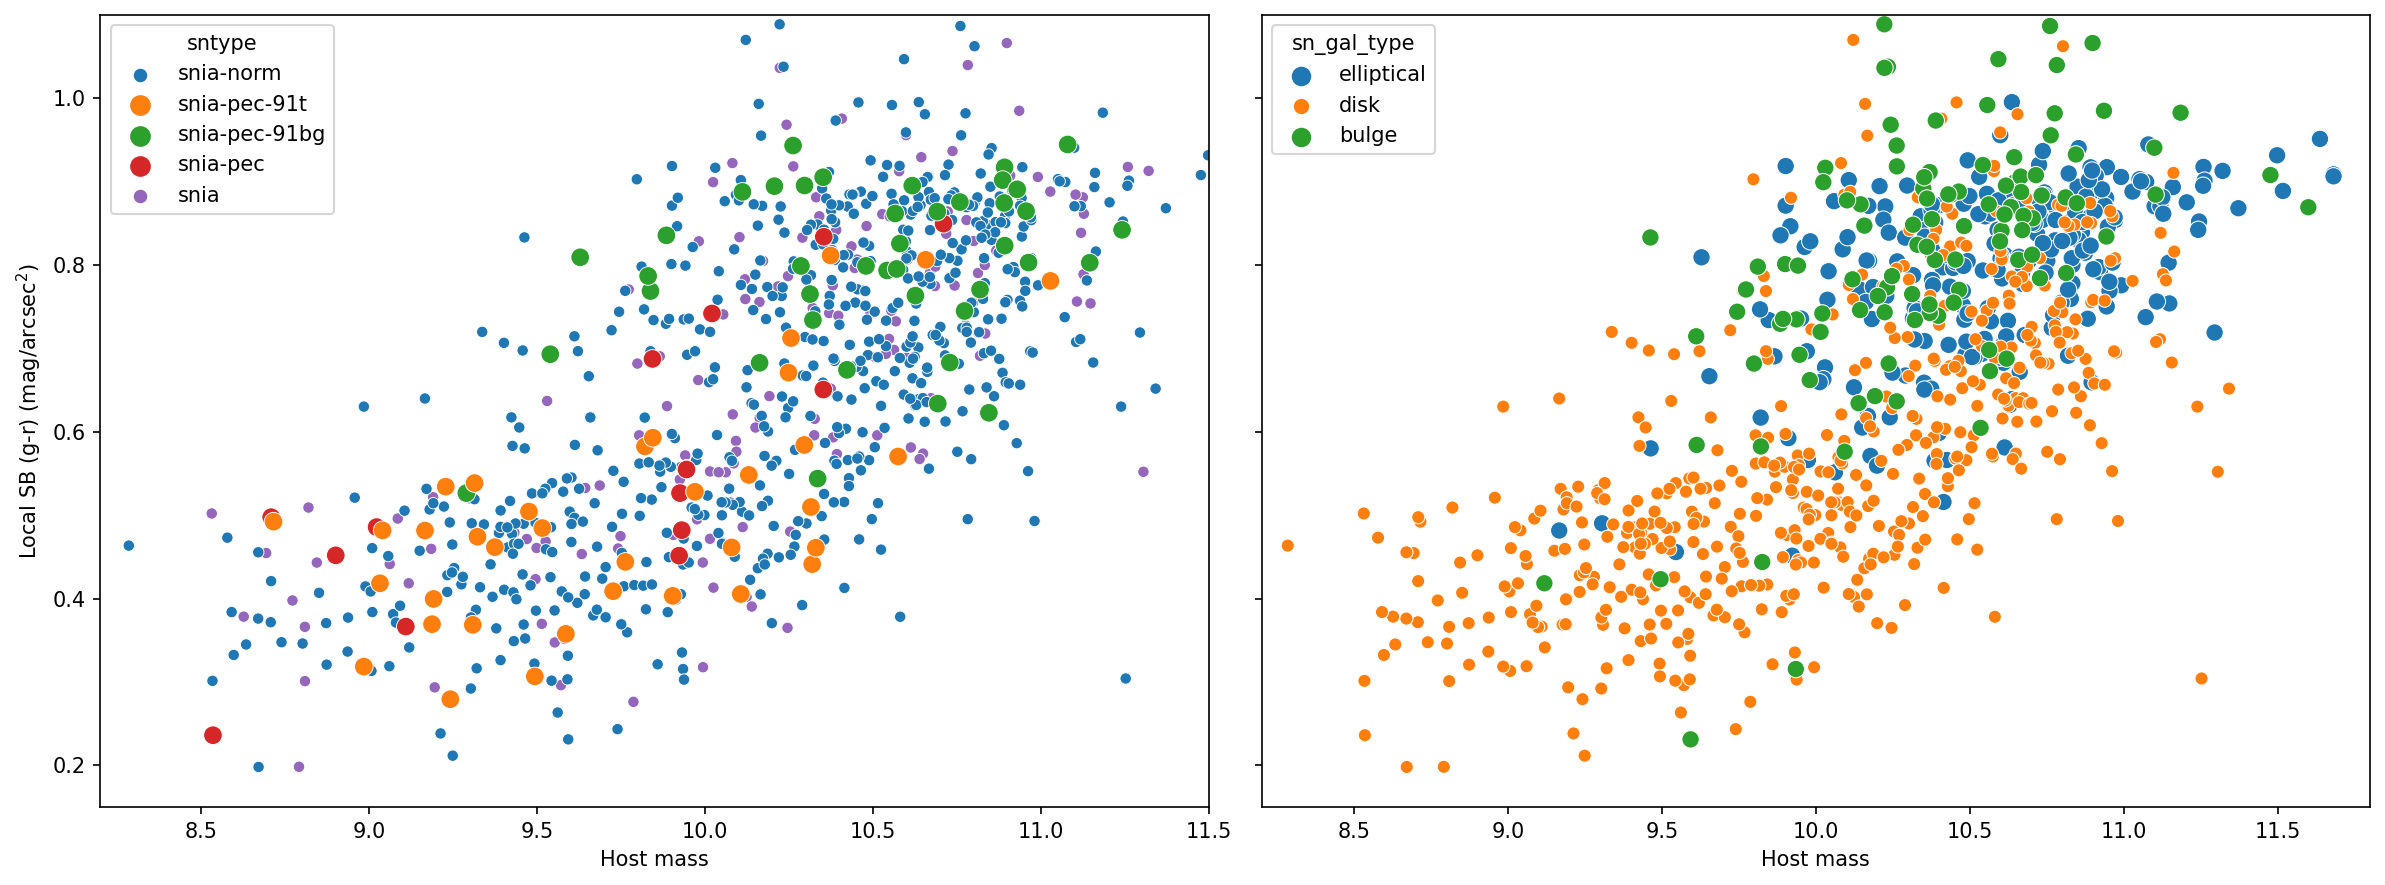

In [254]:
df_new = df_gal.copy()
df_new = df_new[df_new['z'] != 0]
df_new['sn_gal_type'][df_new['sn_gal_type'] == 'disk_nb'] = 'disk'
targ_hd = np.intersect1d(host_data.index, df_new['ztfname'])
df_new.index = df_new['ztfname']
df_new = df_new.loc[targ_hd]
df_new[['PS1_g', 'PS1_r', 'PS1_i', 'PS1_g_err']] = host_data.loc[targ_hd][['PS1_g', 'PS1_r', 'PS1_i', 'PS1_g_err']]

df_new['mass'] = galaxy_mass(df_new['PS1_g'], df_new['PS1_i'], df_new['z'].values)
fig, (ax1, ax2) = plt.subplots(figsize=(16, 6), dpi=150, ncols=2, sharey=True)
df_new= df_new.sort_values('sntype')
cuts = (df_new['z'] < 0.08) & (df_new['PS1_g_err'] <0.1)& (df_new['rss_fit'] <1) & (df_new['gal_type'].apply(lambda x: x[-1]) != 'u') & (df_new['gal_type'] != 'too-close') & (df_new['sn_gal_type'] != 'bar')

y = df_new['sn_c_g'][cuts] - df_new['sn_c_r'][cuts]
x = df_new['mass'][cuts]
hue = df_new['sntype'][cuts]
sizes = np.ones(len(hue.unique())) * 80
sizes[np.where(hue.unique() == 'snia-norm')[0][0]] = 30
sizes[np.where(hue.unique() == 'snia')[0][0]] = 30
hue_order = ['snia-norm', 'snia-pec-91t', 'snia-pec-91bg', 'snia-pec', 'snia']
sns.scatterplot(x=x, y=y, size=hue, sizes=list(sizes.astype(int)), hue=hue, ax=ax1, zorder=0, hue_order=hue_order)
ax1.set_ylim(0.15, 1.3)
ax1.set_xlim(8.2, 11.5)
ax1.set_ylabel(r'Local SB (g-r) (mag/arcsec$^2$)')
ax1.set_xlabel(r'Host mass')

df_new= df_new.sort_values('sn_gal_type')[::-1]

y = df_new['sn_c_g'][cuts] - df_new['sn_c_r'][cuts]
x = df_new['mass'][cuts]
hue = df_new['sn_gal_type'][cuts]
sizes = np.ones(len(hue.unique())) * 70
sizes[np.where(hue.unique() == 'disk')[0][0]] = 40

# hue_order = ['bulge', 'elliptical', 'disk']
color = ['red', 'blue', 'orange']
sns.scatterplot(x=x, y=y, size=hue, sizes=list(sizes.astype(int)), hue=hue, ax=ax2)
ax2.set_ylim(0.15, 1.1)
ax2.set_xlim(8.2, 11.8)
ax2.set_ylabel(r'Local SB (g-r) (mag/arcsec$^2$)')
ax2.set_xlabel(r'Host mass')
plt.tight_layout()

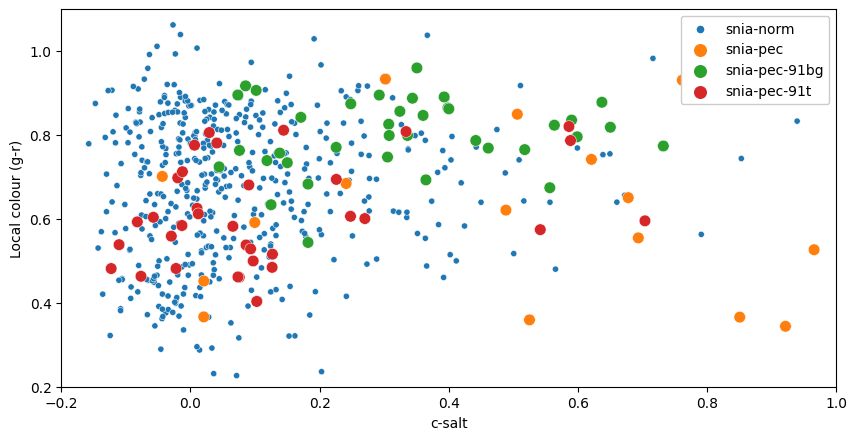

In [258]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
df_gal_s = df_gal.sort_values('sntype')
cuts =(df_gal_s['z'] < 0.06) & (df_gal_s['lc_flag'] == 1) & (df_gal_s['dm15g'] != 0)
 
y = df_gal_s['sn_c_g'][cuts] - df_gal_s['sn_c_r'][cuts]
x = df_gal_s['c_salt'][cuts]
hue = df_gal_s['sntype'][cuts]
sizes = np.ones(len(hue.unique())) * 70
sizes[np.where(hue.unique() == 'snia-norm')[0][0]] = 20
# sizes[np.where(hue.unique() == 'snia')[0][0]] = 40
hue_order = ['snia-norm', 'snia-pec-91t', 'snia-pec-91bg', 'snia-pec', 'snia']
sns.scatterplot(x=x, y=y, size=hue, sizes=list(sizes.astype(int)), hue=hue, ax=ax, zorder=0)

# ax.set_ylim(13, 30)
ax.set_ylim(0.2, 1.1)
ax.set_xlim(-0.2, 1)
ax.set_ylabel(r'Local colour (g-r)')
ax.set_xlabel('c-salt')
# ax.invert_yaxis()
ax.legend(loc=1, framealpha=1)

Text(0.5, 0, 'Bulge/Disk (Effective radius)')

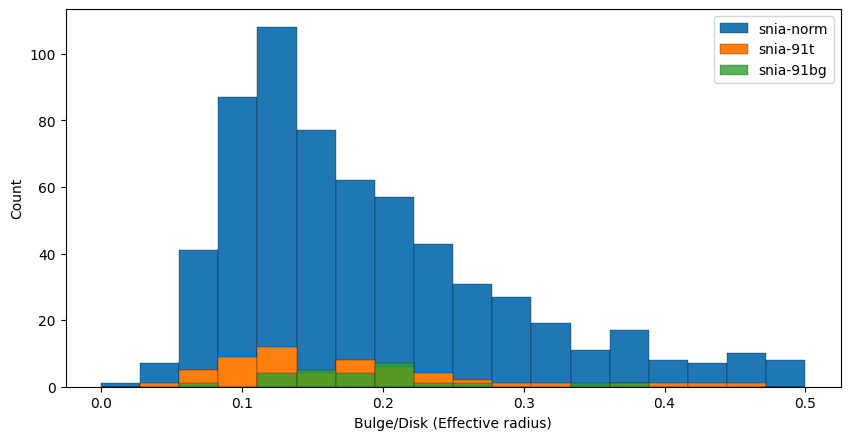

In [262]:
fig, ax1= plt.subplots(figsize=(10, 5), dpi=100)
cuts =  (df_gal['gal_type'].apply(lambda x: x[-1]) != 'u') & (df_gal['gal_type'] != 'too-close')

df_gal_c = df_gal[cuts]
local_norm = df_gal_c[df_gal_c['sntype'] == 'snia-norm']
local_norm_c = local_norm['bd_size']/1.678

local_91bg = df_gal_c[df_gal_c['sntype'] == 'snia-pec-91bg']
local_91bg_c = local_91bg['bd_size']/1.678

local_91t = df_gal_c[df_gal_c['sntype'] == 'snia-pec-91t']
local_91t_c = local_91t['bd_size']/1.678

bins = 18
range_r = (0, 0.5)
local_norm_c.hist(bins=bins, range=range_r, label='snia-norm', ax=ax1, ec='black', lw=0.2, alpha=1)
local_91t_c.hist(bins=bins, range=range_r, label='snia-91t', ax=ax1, ec='black', lw=0.2, alpha=1)
local_91bg_c.hist(bins=bins, range=range_r, label='snia-91bg', ax=ax1, ec='black', lw=0.2, alpha=0.8)
ax1.grid(False)
ax1.legend()
ax1.set_ylabel('Count')
ax1.set_xlabel('Bulge/Disk (Effective radius)')

Text(0.5, 0, 'R$_{25}$(g)')

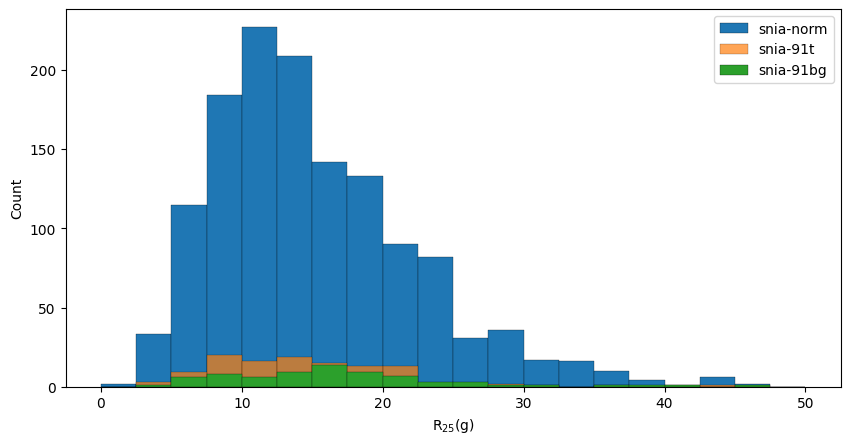

In [231]:
fig, ax1= plt.subplots(figsize=(10, 5), dpi=100)

local_norm = df_gal[df_gal['sntype'] == 'snia-norm']
local_norm_c = local_norm['R25_g']

local_91bg = df_gal[df_gal['sntype'] == 'snia-pec-91bg']
local_91bg_c = local_91bg['R25_g']

local_91t = df_gal[df_gal['sntype'] == 'snia-pec-91t']
local_91t_c = local_91t['R25_g']

bins = 20
range_r = (0, 50)
local_norm_c.hist(bins=bins, range=range_r, label='snia-norm', ax=ax1, ec='black', lw=0.2, alpha=1)
local_91t_c.hist(bins=bins, range=range_r, label='snia-91t', ax=ax1, ec='black', lw=0.2, alpha=0.7, zorder=1)
local_91bg_c.hist(bins=bins, range=range_r, label='snia-91bg', ax=ax1, ec='black', lw=0.2, alpha=1)
ax1.grid(False)
ax1.legend()
ax1.set_ylabel('Count')
ax1.set_xlabel('R$_{25}$(g)')

In [345]:
df_gal.keys()

Index(['ztfname', 'z', 'sn_ra', 'sn_dec', 'host_ra', 'host_dec', 'gal_type',
       'gal_pa', 'gal_ecc', 'gal_se', 'separation', 'sersic_n', 'SB_center_g',
       'SB_center_r', 'sn_radial', 'sn_height', 'sn_gal_type', 'sn_c_g',
       'sn_c_r', 'R25_g', 'R25_r', 'R26p5_g', 'R26p5_r', 'n_fits', 'bd_size',
       'x1_salt', 'c_salt', 'sntype', 'abs_g_salt', 'abs_r_salt', 'lc_flag',
       'abs_g', 'abs_r', 'dm15g', 'dm15r', 'dmm10g', 'dmm10r', 'gr_peak',
       'gr_15', 'trg', 'abs_g_err', 'abs_r_err', 'dm15g_err', 'dm15r_err',
       'dmm10g_err', 'dmm10r_err', 'gr_peak_err', 'gr_15_err'],
      dtype='object')

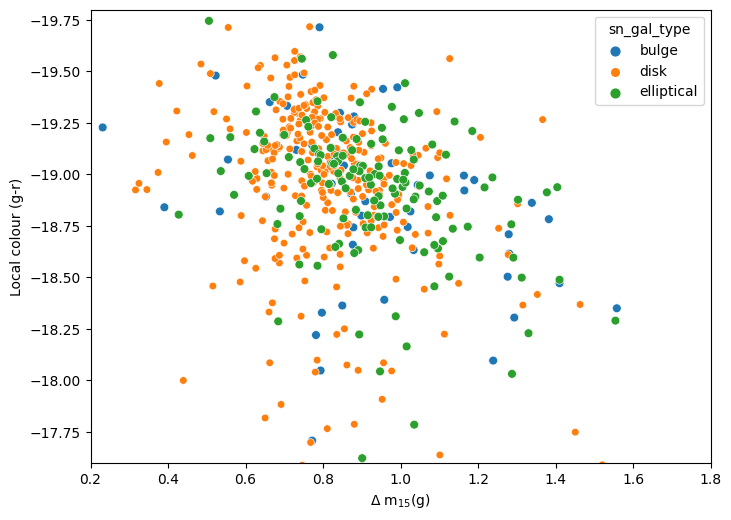

In [289]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
sub_data = df_gal_c.copy()[df_gal_c['sntype'] == 'snia-norm']
sub_data['sn_gal_type'][sub_data['sn_gal_type'] == 'disk_nb'] = 'disk'
cuts1 = (sub_data['z'] < 0.1) & (sub_data['rss_fit'] <1) & (sub_data['gal_type'].apply(lambda x: x[-1]) != 'u') & (sub_data['gal_type'] != 'too-close') & (sub_data['sn_gal_type'] != 'bar')

sub_data = sub_data.sort_values('sn_gal_type')
cuts2 =  (sub_data['lc_flag'] == 1) & (sub_data['dm15g'] != 0) & (sub_data['dm15g_err'] < 0.2)  & (sub_data['abs_g_err'] < 0.2) 
cuts = cuts1 & cuts2

y = sub_data['abs_g'][cuts]
x = sub_data['dm15g'][cuts]
hue = sub_data['sn_gal_type'][cuts]
sizes = np.ones(len(hue.unique())) * 30
sizes[np.where(hue.unique() == 'elliptical')[0][0]] = 40
sizes[np.where(hue.unique() == 'bulge')[0][0]] = 40
# # sizes[np.where(hue.unique() == 'snia')[0][0]] = 40
# hue_order = ['snia-norm', 'snia-pec-91t', 'snia-pec-91bg', 'snia-pec', 'snia']
sns.scatterplot(x=x, y=y, size=hue, sizes=list(sizes.astype(int)), hue=hue, ax=ax, zorder=0)

ax.set_ylim(-19.8, -17.6)
ax.set_xlim(0.2, 1.8)
ax.set_ylabel(r'Local colour (g-r)')
ax.set_xlabel('$\Delta$ m$_{15}$(g)')
ax.invert_yaxis()
# ax.legend(loc=1, framealpha=1)

In [1100]:
df_gal[df_gal['sn_gal_type'] == 'bar']['ztfname']

352     ZTF18abjwahi
362     ZTF18abktphg
923     ZTF19aaknacv
937     ZTF19aakrawk
939     ZTF19aaksqsz
1035    ZTF19aanramr
1119    ZTF19aartuli
1499    ZTF19absfopz
1692    ZTF19acgmkrt
2067    ZTF20aamerev
2234    ZTF20aavnnqo
2561    ZTF20abtfnpl
3030    ZTF18acrxnme
Name: ztfname, dtype: object

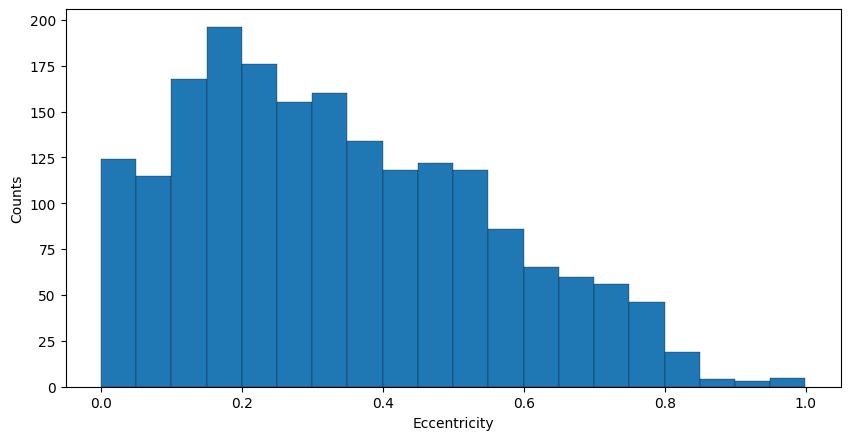

In [1099]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
df_gal['gal_ecc'][(df_gal['gal_ecc'] > 0) & (df_gal['gal_ecc'] < 1)].hist(bins=20, ec='black', lw=0.2, ax=ax)
ax.set_xlabel('Eccentricity')
ax.set_ylabel('Counts')
ax.grid(False)

In [1101]:
df_gal.keys()

Index(['ztfname', 'z', 'sn_ra', 'sn_dec', 'host_ra', 'host_dec', 'gal_type',
       'gal_pa', 'gal_ecc', 'gal_se', 'separation', 'sersic_n', 'SB_center_g',
       'SB_center_r', 'sn_radial', 'sn_height', 'sn_gal_type', 'sn_c_g',
       'sn_c_r', 'R25_g', 'R25_r', 'R26p5_g', 'R26p5_r', 'n_fits', 'bd_size',
       'x1_salt', 'c_salt', 'sntype', 'abs_g_salt', 'abs_r_salt', 'lc_flag',
       'abs_g', 'abs_r', 'dm15g', 'dm15r', 'dmm10g', 'dmm10r', 'gr_peak',
       'gr_15', 'trg', 'abs_g_err', 'abs_r_err', 'dm15g_err', 'dm15r_err',
       'dmm10g_err', 'dmm10r_err', 'gr_peak_err', 'gr_15_err'],
      dtype='object')

In [200]:
keys = ['ztfname', 'z', 'sn_ra', 'sn_dec', 'host_ra', 'host_dec', 'gal_type', 'gal_pa', 'gal_ecc', 'gal_se', 'separation', 'sersic_n',
        'SB_center_g', 'SB_center_r', 'sn_radial', 'sn_height', 'sn_gal_type', 'sn_c_g', 'sn_c_r', 'R25_g', 'R25_r', 'R26p5_g', 'R26p5_r',
        'n_fits', 'rss_fit', 'bd_size', 'x1_salt', 'c_salt', 'sntype', 'abs_g_salt', 'abs_r_salt', 'lc_flag', 'abs_g', 'abs_r', 'dm15g', 'dm15r',
        'dmm10g', 'dmm10r', 'gr_peak', 'gr_15', 'trg', 'abs_g_err', 'abs_r_err', 'dm15g_err', 'dm15r_err','dmm10g_err', 'dmm10r_err', 'gr_peak_err', 'gr_15_err']
def decomp_pars(sn_name, verbose=False):
    sn_c1 = c1_df[c1_df['sn_name'] == sn_name]
    if sn_c1['ue_g'].values != 0:
        try:
            gd_i = glp.galaxy_decomp(sn_name, verbose=verbose, mask=False, size='z', source='save', catalog='ztf')
            gd_i.load_main_run()
            bd_i = glp.BDdecomp(sn_name, gd_i)
            bd_i.load_main_BD()
            bd_i.galaxy_pars()
            
            df_i = pd.DataFrame(columns=keys)
            df_i.loc[0] = bd_i.galaxy
        except (TypeError, ZeroDivisionError, RuntimeError) as err:
            df_i = pd.DataFrame(columns=keys)
            df_i.loc[0] = [sn_name, *np.zeros(len(keys)-1)]
    else:
        df_i = pd.DataFrame(columns=keys)
        df_i.loc[0] = [sn_name, *np.zeros(len(keys)-1)]

    df_i.to_csv('csv_files/SNIa_galaxy_3.csv', mode='a', header=False)

In [201]:
for i, sn_name in enumerate(targets):
    print(f'{i}/{len(targets)}') if i%100 == 0 else None
    decomp_pars(sn_name)

0/3035
100/3035
200/3035
300/3035
400/3035
500/3035
600/3035
700/3035
800/3035
900/3035
1000/3035
1100/3035
1200/3035
1300/3035
1400/3035
1500/3035
1600/3035
1700/3035
1800/3035
1900/3035
2000/3035
2100/3035
2200/3035
2300/3035
2400/3035
2500/3035
2600/3035
2700/3035
2800/3035
2900/3035
3000/3035
